### Import the libraries

In [54]:
from sklearn.model_selection import  learning_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, metrics, tree 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [4]:
bioresponce = pd.read_csv('./bioresponse.csv', header=0, sep=',')
bioresponce_target = bioresponce.Activity.values
bioresponce_data = bioresponce.iloc[:, 1:]

In [9]:
# splitting the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(bioresponce_data, 
                                                                    bioresponce_target, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

### Train classifiers 

In [62]:
# a function that will return a list with the values of all the required metrics for the task
def get_metrics(test_value, predictions_value):
    metrics_value = [metrics.precision_score(test_value, predictions_value),
               metrics.recall_score(test_value, predictions_value),
               metrics.accuracy_score(test_value, predictions_value),
               metrics.f1_score(test_value, predictions_value),
               metrics.log_loss(test_value, predictions_value)]
    return metrics_value

In [ ]:
# further all the necessary classifiers will be trained with a variable value of max_depth

##### Small decision tree

In [109]:
sdt = tree.DecisionTreeClassifier(max_depth=3, random_state=1)
sdt.fit(train_data, train_labels)
predictions_sdt = sdt.predict(test_data)

metrics_sdt = get_metrics(test_labels, predictions_sdt)

##### Deep decision tree

In [64]:
ddt = tree.DecisionTreeClassifier(max_depth=30, random_state=1)
ddt.fit(train_data, train_labels)
predictions_ddt = ddt.predict(test_data)

metrics_ddt = get_metrics(test_labels, predictions_ddt)

##### Random forest on small trees

In [65]:
rfst = RandomForestClassifier(max_depth=3, random_state=1)
rfst.fit(train_data, train_labels)
predictions_rfst = rfst.predict(test_data)

metrics_rfst = get_metrics(test_labels, predictions_rfst)

##### Random forest on deep trees

In [66]:
rfdt = RandomForestClassifier(max_depth=30, random_state=1)
rfdt.fit(train_data, train_labels)
predictions_rfdt = rfdt.predict(test_data)

metrics_rfdt = get_metrics(test_labels, predictions_rfdt)

### Metrics 

In [67]:
# Output of all required metrics of all trained classifiers
metrics_name = ['Precision', 'Recall', 'Accuracy', 'F1-score', 'Log-loss']
metrics_bioresponse = pd.DataFrame({'Metrics': metrics_name, 
                                    'Small decision tree': metrics_sdt,
                                    'Deep decision tree': metrics_ddt,
                                    'Random forest on small trees': metrics_rfst,
                                    'Random forest on deep trees': metrics_rfdt})
metrics_bioresponse

,Metrics,Small decision tree,Deep decision tree,Random forest on small trees,Random forest on deep trees
0,Precision,0.785381,0.733990,0.749211,0.831650
1,Recall,0.811897,0.718650,0.763666,0.794212
2,Accuracy,0.773535,0.700710,0.728242,0.797513
3,F1-score,0.798419,0.726239,0.756369,0.812500
4,Log-loss,7.821935,10.337209,9.386317,6.993713


### Precision-recall and ROC curves 

In [97]:
# a function that plot a precision-recall graph
def get_precision_recall_graph(model):
    prec, rec, thresh = metrics.precision_recall_curve(test_labels, model.predict_proba(test_data)[:,1])
    #plt.figure(figsize=(9, 6))
    plt.grid()
    plt.plot(thresh, prec[:-1], label="Precision")
    plt.plot(thresh, rec[:-1], label="Recall")
    plt.xlabel(u"Threshold",fontsize = 10)
    #plt.title(u'Precision-Recall curve',fontsize = 15)
    plt.legend(fontsize = 10)   

In [205]:
# a function that plot a ROC graph
def get_ROC_curves_graph(model):
    
    fpr, tpr, thr = roc_curve(test_labels, model.predict_proba(test_data)[:,1])

    #plt.figure(figsize = (9,6))
    plt.plot(fpr, tpr, label=u'ROC \n'+'AUC = ' + str(round(metrics.roc_auc_score(predictions_rfdt, test_labels),2)))
    plt.grid()
    plt.xlabel("false positive rate",fontsize = 10)
    plt.ylabel("true positive rate",fontsize = 10)
    #plt.title(u"ROC curve",fontsize = 10)
    plt.legend(fontsize = 10)

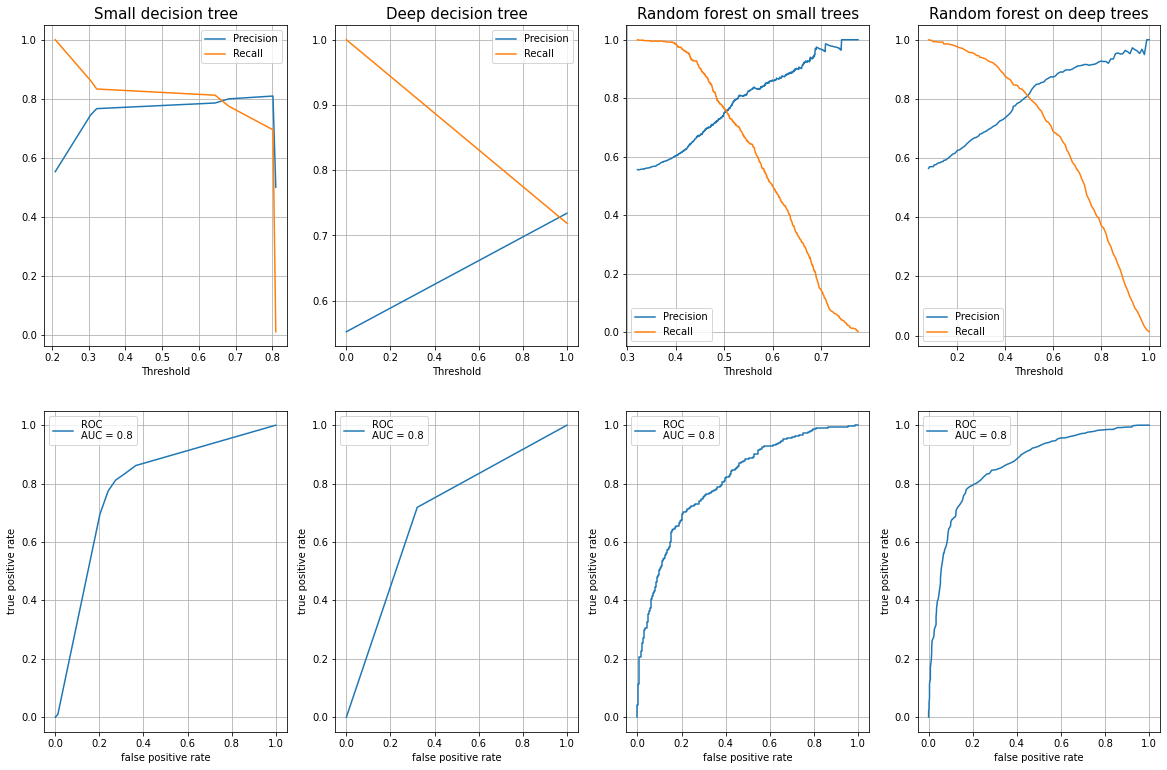

In [110]:
models = [sdt,ddt,rfst,rfdt]
models_names = ['Small decision tree', 'Deep decision tree', 'Random forest on small trees', 'Random forest on deep trees']

plt.figure(figsize=(20, 13))

for i in range(len(models)):
    plt.subplot(2, 4, i+1)
    plt.title(models_names[i],fontsize = 15)
    get_precision_recall_graph(models[i])

    plt.subplot(2, 4, i+5)
    get_ROC_curves_graph(models[i])



### Classifier who avoids Type II (False Negative) errors 

In [190]:
# finding the optimal RandomForestClassifier hyperparameters for the largest Recall parameter

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfdt, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        scoring='recall',
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(train_data, train_labels)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 800,
 'min_samples_split': 50,
 'min_samples_leaf': 39,
 'max_features': 'log2',
 'max_depth': 1,
 'bootstrap': True}

In [204]:
# training the model with the hyperparameters found from the previous step
rfdt2 = RandomForestClassifier(n_estimators = 800, min_samples_split = 50, min_samples_leaf = 39, 
                                max_features = 'log2', 
                                max_depth = 1, bootstrap = True, random_state=1)

rfdt2.fit(train_data, train_labels)
predictions_rfdt2 = rfdt2.predict(test_data)

metrics_rfdt2 = get_metrics(test_labels, predictions_rfdt2)

tn, fp, fn, tp = metrics.confusion_matrix(test_labels, predictions_rfdt2).ravel()
print('False Negative: ', fn)

False Negative:  1


In [200]:
# input metrics for that model
for i in range(len(metrics_rfdt2)):
    print(metrics_name[i], ': ', metrics_rfdt2[i])

Precision :  0.5630099728014506
Recall :  0.9983922829581994
Accuracy :  0.5710479573712256
F1-score :  0.7199999999999999
Log-loss :  14.815820963324347


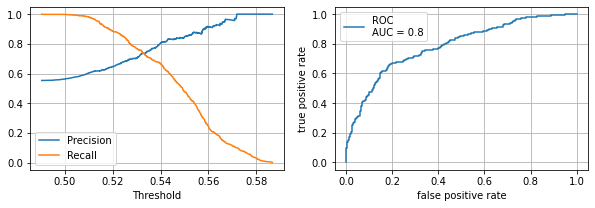

In [201]:
# input plots for that model

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
get_precision_recall_graph(rfdt2)

plt.subplot(1, 2, 2)
get_ROC_curves_graph(rfdt2)